In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn import datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [38]:
# download del data set
iris = datasets.load_iris()

X = iris.data
y = iris.target

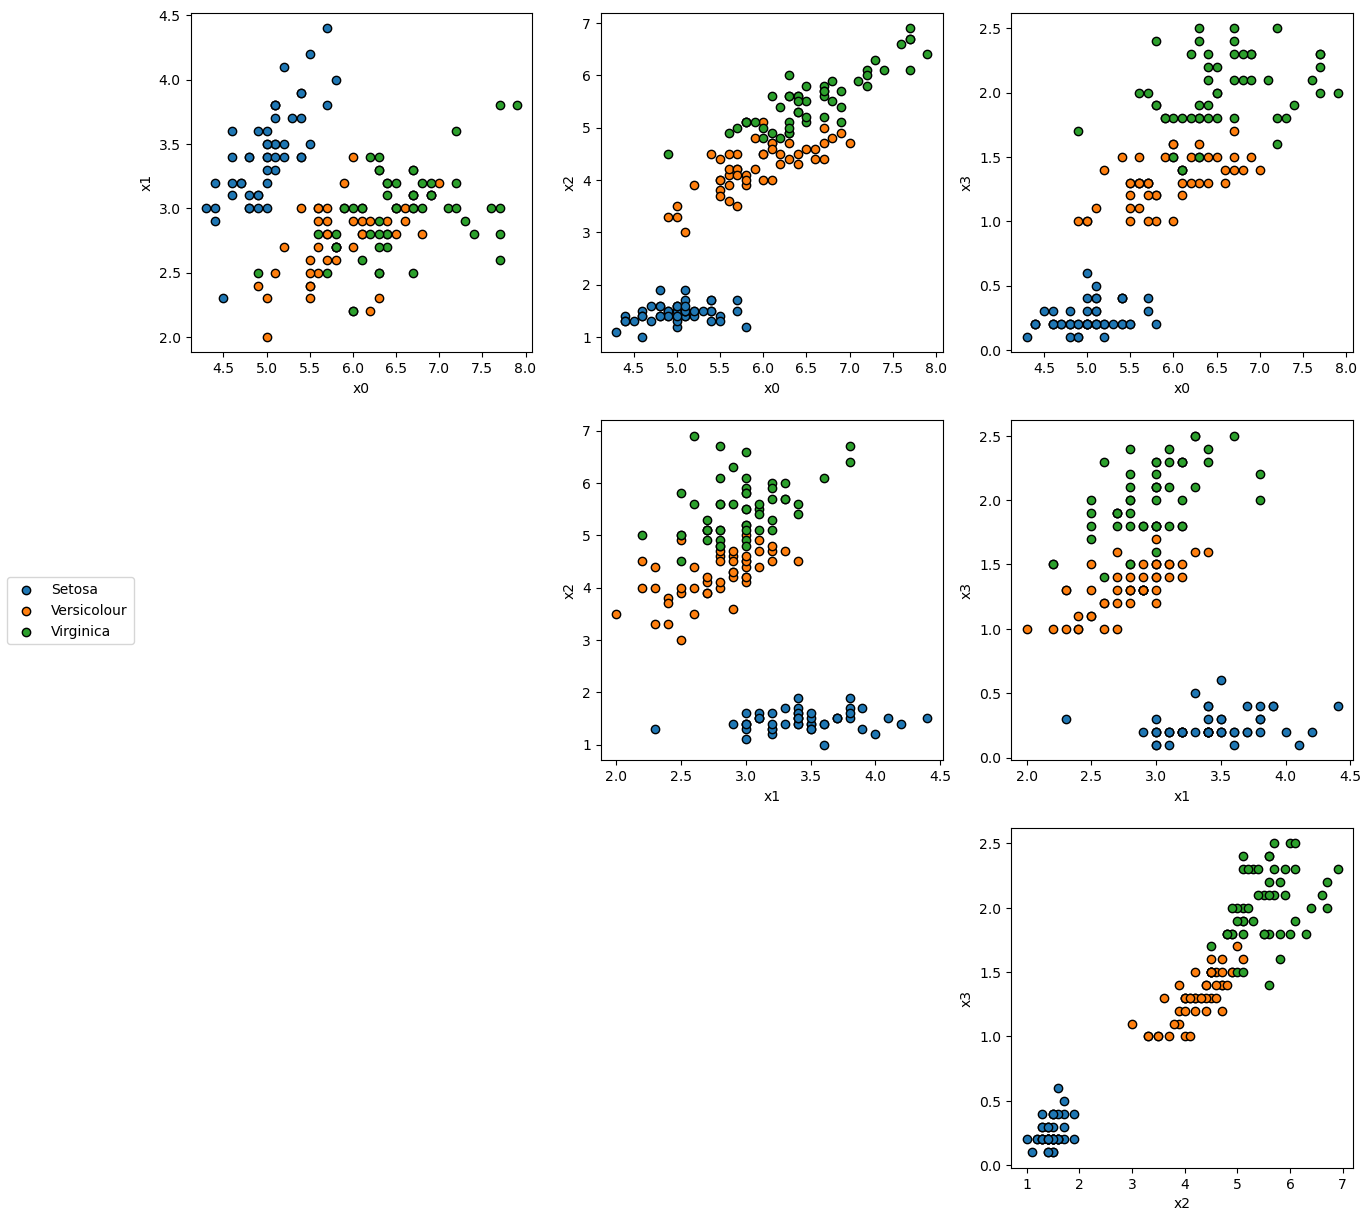

In [39]:
fig = plt.figure(figsize=(15, 15))

n_features = X.shape[1]


# plot di tutte le coppie di feature
for i in range(n_features):
    for j in range(i+1, n_features):
        sub_plot = plt.subplot(3,3,3*i+j)
        sub_plot.set_xlabel(f'x{i}')
        sub_plot.set_ylabel(f'x{j}')
        sub_plot.scatter(X[y==0,i],X[y==0,j],edgecolor='k')
        sub_plot.scatter(X[y==1,i],X[y==1,j],edgecolor='k')
        sub_plot.scatter(X[y==2,i],X[y==2,j],edgecolor='k')
    
fig.legend(('Setosa','Versicolour','Virginica'),loc='center left')
plt.show()

In [40]:
# Effettuiamo la PCA su tutte le componenti per ottenere la varianza totale
pca = decomposition.PCA(n_components=4, svd_solver='full')
pca.fit(X)

total_variation = np.sum(pca.singular_values_**2)

print(f'Varianza totale: {total_variation:5.2f}')

Varianza totale: 681.37


In [41]:
# Eseguiamo la PCA con due e tre componenti per capire quante dimensioni trattenere
pca2 = decomposition.PCA(n_components=2, svd_solver='arpack')
pca2.fit(X)

X_2 = pca2.transform(X)

tv_2 = np.sum(pca2.singular_values_**2)

pca3 = decomposition.PCA(n_components=3, svd_solver='arpack')
pca3.fit(X)

X_3 = pca3.transform(X)

tv_3 = np.sum(pca3.singular_values_**2)

print(f'Varianza totale a 2 componenti {tv_2:5.2f}, pari al {tv_2*100/total_variation:4.2f}% del totale')
print(f'Varianza totale a 3 componenti {tv_3:5.2f}, pari al {tv_3*100/total_variation:4.2f}% del totale')


Varianza totale a 2 componenti 666.17, pari al 97.77% del totale
Varianza totale a 3 componenti 677.82, pari al 99.48% del totale


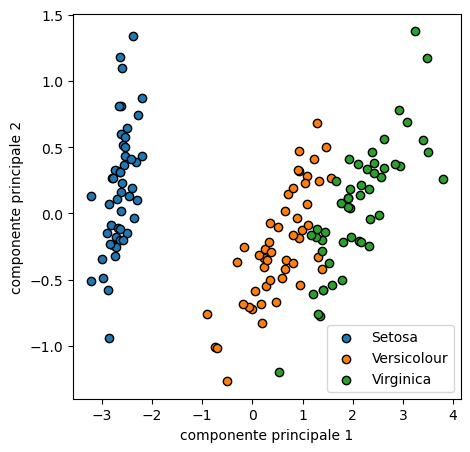

In [42]:
# Visualizziamo il data set trasformato a due componenti
fig = plt.figure(figsize=(5, 5))

plt.xlabel('componente principale 1')
plt.ylabel('componente principale 2')

plt.scatter(X_2[y==0,0],X_2[y==0,1],label='Setosa', edgecolor='k')
plt.scatter(X_2[y==1,0],X_2[y==1,1],label='Versicolour',edgecolor='k')
plt.scatter(X_2[y==2,0],X_2[y==2,1],label='Virginica',edgecolor='k')

plt.legend()

plt.show()

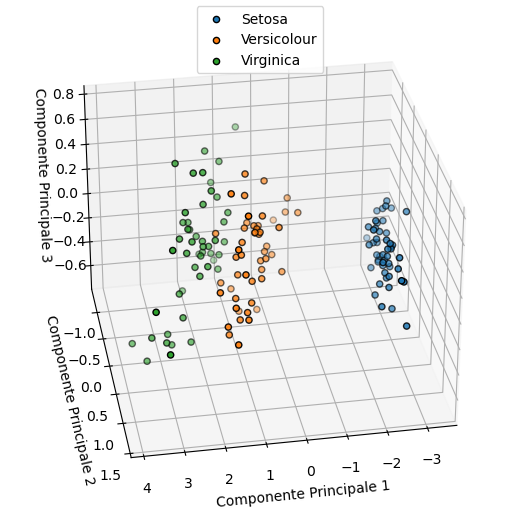

In [43]:
# Visualizziamo il data set a tre dimensioni
fig = plt.figure(figsize=(5, 5))

ax = axes3d.Axes3D(fig)
fig.add_axes(ax)

ax.set_xlabel('Componente Principale 1')
ax.set_ylabel('Componente Principale 2')
ax.set_zlabel('Componente Principale 3')

ax.scatter(X_3[y==0,0],X_3[y==0,1],X_3[y==0,2],label='Setosa', edgecolor='k')
ax.scatter(X_3[y==1,0],X_3[y==1,1],X_3[y==1,2],label='Versicolour',edgecolor='k')
ax.scatter(X_3[y==2,0],X_3[y==2,1],X_3[y==2,2],label='Virginica',edgecolor='k')

ax.view_init(elev=30, azim=80)

fig.legend(('Setosa','Versicolour','Virginica'),loc='upper center')
plt.show()



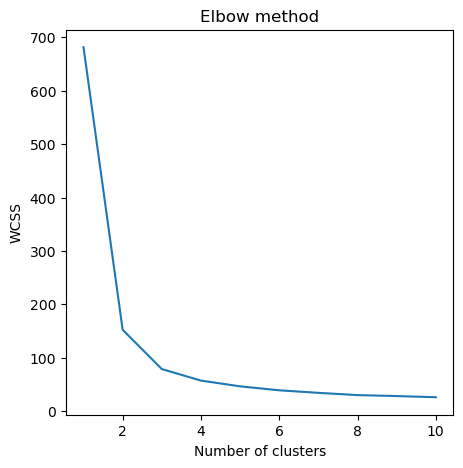

In [44]:
# Determiniamo il numero ottimo di cluster con l'elbow method
wcss = []
kmeans = [] # lista dei modelli kmeans da testare

for i in range(1,11):
    kmeans.append(KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0))
    kmeans[i-1].fit(X)
    wcss.append(kmeans[i-1].inertia_)

plt.figure(figsize=(5,5))
plt.plot(range(1,11),wcss)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

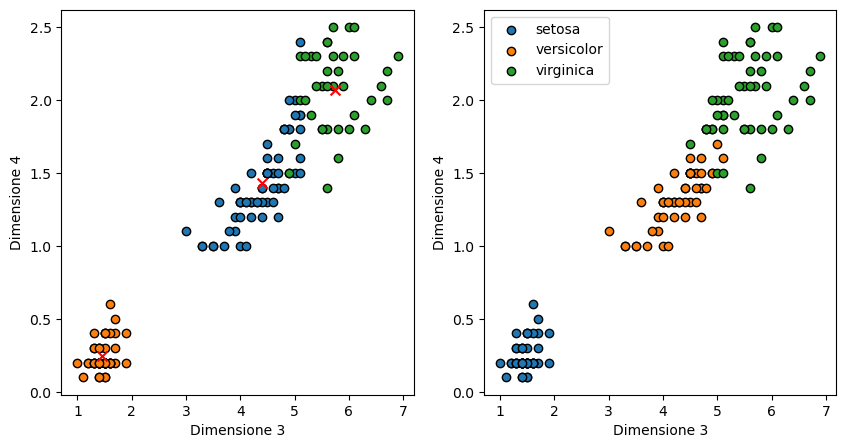

In [45]:
# Stabiliamo empiricamente che vanno bene tre cluster e quindi tratteniamo il modello di indice 2
best_model = kmeans[2]

y_best_model = best_model.fit_predict(X)

# Confrontiamo il plot delle ultime due dimensioni tra il risultato del clustering e il data set originale
labels = list(iris.target_names)
labels.append('Centroids')

fig = plt.figure(figsize=(10,5))
subplt = fig.add_subplot(1,2,1)
subplt.set_xlabel('Dimensione 3')
subplt.set_ylabel('Dimensione 4')

subplt.scatter(X[y_best_model==0,2],X[y_best_model==0,3],edgecolor='k')
subplt.scatter(X[y_best_model==1,2],X[y_best_model==1,3],edgecolor='k')
subplt.scatter(X[y_best_model==2,2],X[y_best_model==2,3],edgecolor='k')

# inseriamo anche i centroidi
subplt.scatter(best_model.cluster_centers_[:,2],best_model.cluster_centers_[:,3], s=50, marker='x', c='r')

# facciamo il plot del data set
subplt = fig.add_subplot(1,2,2)
subplt.set_xlabel('Dimensione 3')
subplt.set_ylabel('Dimensione 4')

subplt.scatter(X[y==0,2],X[y==0,3],edgecolor='k')
subplt.scatter(X[y==1,2],X[y==1,3],edgecolor='k')
subplt.scatter(X[y==2,2],X[y==2,3],edgecolor='k')

plt.legend(labels)
plt.show()



In [46]:
# Implemeniamo una routine di swap degli indici dei cluster per allinearli alle etichette di classe
def remap_cluster(ycluster, remap):
    """remap_cluster: rimappa gli indici di ycluster secondo la lista di coppie che indicano il verso dello swap
    
        Args:
            ycluster (ndarray[int]): array delle etichette di cluster
            remap (tuple[tuple[int,int]]): tupla delle coppie che indicano il verso di swap
        
        Retruns:
            un vettore ndarray[int] contenente gli indici ri-mappati
    """

    y_remap = np.ndarray(ycluster.shape, ycluster.dtype)
    
    y_remap.fill(-1)
    
    for da,a in remap:
        y_remap[ycluster==da] = a
    
    return y_remap

In [47]:
# Eseguiamo il remap: 0 --> 1, 1 --> 0, 2 --> 2
y_remap = remap_cluster(y_best_model, ((0,1),(1,0),(2,2)))

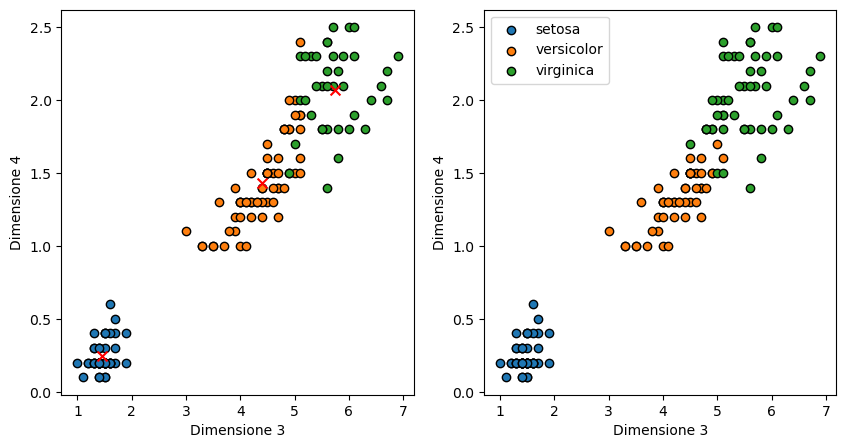

In [48]:
# Rifacciamo il plot
labels = list(iris.target_names)
labels.append('Centroids')

fig = plt.figure(figsize=(10,5))
subplt = fig.add_subplot(1,2,1)
subplt.set_xlabel('Dimensione 3')
subplt.set_ylabel('Dimensione 4')

subplt.scatter(X[y_remap==0,2],X[y_remap==0,3],edgecolor='k')
subplt.scatter(X[y_remap==1,2],X[y_remap==1,3],edgecolor='k')
subplt.scatter(X[y_remap==2,2],X[y_remap==2,3],edgecolor='k')

# inseriamo anche i centroidi
subplt.scatter(best_model.cluster_centers_[:,2],best_model.cluster_centers_[:,3], s=50, marker='x', c='r')

# facciamo il plot del data set
subplt = fig.add_subplot(1,2,2)
subplt.set_xlabel('Dimensione 3')
subplt.set_ylabel('Dimensione 4')

subplt.scatter(X[y==0,2],X[y==0,3],edgecolor='k')
subplt.scatter(X[y==1,2],X[y==1,3],edgecolor='k')
subplt.scatter(X[y==2,2],X[y==2,3],edgecolor='k')

plt.legend(labels)
plt.show()

[[50  0  0]
 [ 0 48  2]
 [ 0 14 36]]


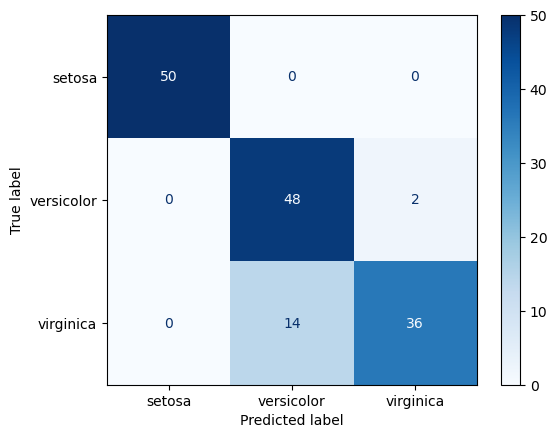

In [49]:
# Calcoliamo e mostriamo la matrice di confusione
cm = confusion_matrix(y, y_remap)

print(cm)

ConfusionMatrixDisplay.from_predictions(y, y_remap, display_labels=iris.target_names, cmap=plt.cm.Blues)

In [50]:
# Definiamo la funzione di calcolo di Purity e Gini index
def cluster_metrics(cm):
    """cluster_metrics: calcola la Purity e l'indice di Gini da una matrice di confusione

    Args:
        cm (ndarray): la matrice di confusione che ha per righe le etichette e per colonne gli indici di cluster
    
    Returns:
        tuple[float, float]: la coppia delle metriche richieste
    """
    
    Mval = [np.sum(cm[:,i]) for i in range(cm.shape[1])]
    
    M = np.array(Mval)
    
    Pval = [np.max(cm[:,i]) for i in range(cm.shape[1])]
    
    P = np.array(Pval)
    
    purity = np.sum(P)/np.sum(M)
    
    gini_val = [np.sum((cm[i,:]/M[i])**2) for i in range(cm.shape[0])]
    
    gini_j = 1 - np.array(gini_val)
    
    gini = np.dot(gini_j, M)/np.sum(M)
    
    return purity, gini

In [52]:
# Calcoliamo le metriche di bontà per il clustering a 4 dimensioni
purity, gini = cluster_metrics(cm)

print(f'Purity: {purity:5.2f}\nGini index: {gini:5.2f}')

Purity:  0.89
Gini index:  0.16


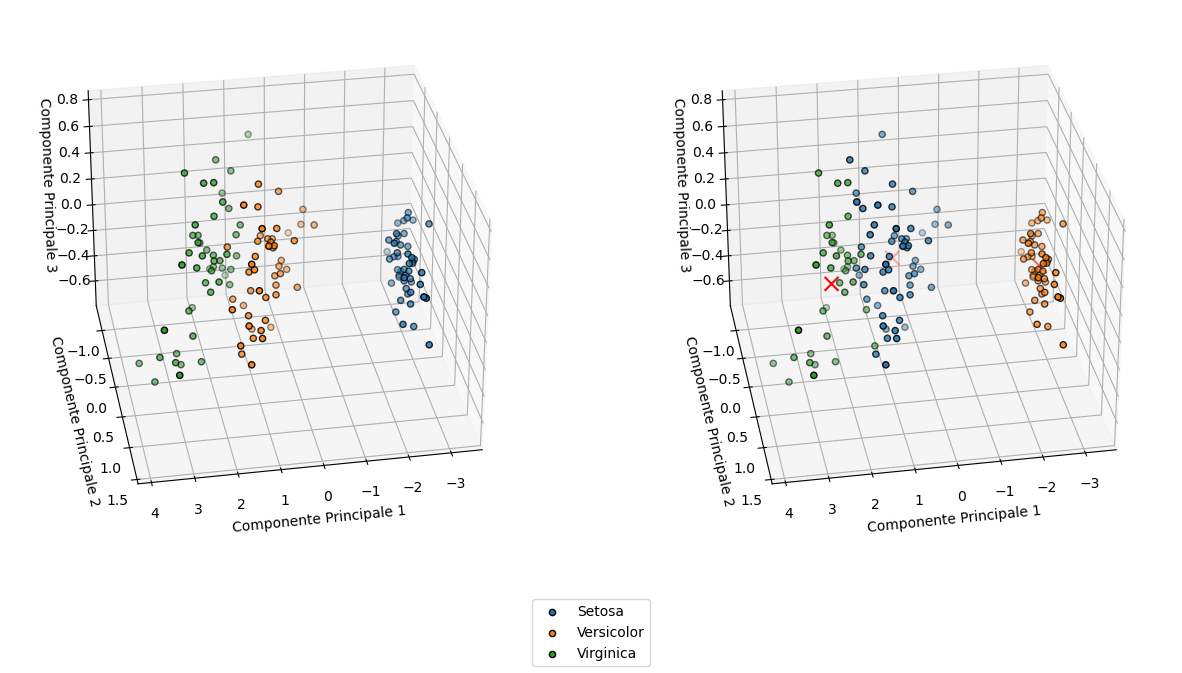

In [53]:
# Eseguiamo il Kmeans sul data set a tre dimensioni
kmeans3 = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)

y_3_kmeans = kmeans3.fit_predict(X_3)

# Eseguiamo il plot dei risultati del clustering
fig = plt.figure(figsize=(15, 8))

# Grafico 1: data set reale
subplt = fig.add_subplot(121,projection='3d')

subplt.set_xlabel('Componente Principale 1')
subplt.set_ylabel('Componente Principale 2')
subplt.set_zlabel('Componente Principale 3')

subplt.scatter(X_3[y==0,0],X_3[y==0,1],X_3[y==0,2],label='Setosa', edgecolor='k')
subplt.scatter(X_3[y==1,0],X_3[y==1,1],X_3[y==1,2],label='Versicolour',edgecolor='k')
subplt.scatter(X_3[y==2,0],X_3[y==2,1],X_3[y==2,2],label='Virginica',edgecolor='k')

subplt.view_init(elev=30, azim=80)

# Grafico 2: risultati del clustering con i centri cluster

subplt = fig.add_subplot(122,projection='3d')

subplt.set_xlabel('Componente Principale 1')
subplt.set_ylabel('Componente Principale 2')
subplt.set_zlabel('Componente Principale 3')

subplt.scatter(X_3[y_3_kmeans==0,0],X_3[y_3_kmeans==0,1],X_3[y_3_kmeans==0,2],label='Setosa', edgecolor='k')
subplt.scatter(X_3[y_3_kmeans==1,0],X_3[y_3_kmeans==1,1],X_3[y_3_kmeans==1,2],label='Versicolour',edgecolor='k')
subplt.scatter(X_3[y_3_kmeans==2,0],X_3[y_3_kmeans==2,1],X_3[y_3_kmeans==2,2],label='Virginica',edgecolor='k')

subplt.scatter(kmeans3.cluster_centers_[:,0],
               kmeans3.cluster_centers_[:,1],
               kmeans3.cluster_centers_[:,2],
               s=100,
               marker='x',
               c='r')

subplt.view_init(elev=30, azim=80)

fig.legend(('Setosa','Versicolor','Virginica'),loc='lower center')

plt.show()

Purity:  0.89
Gini index:  0.16


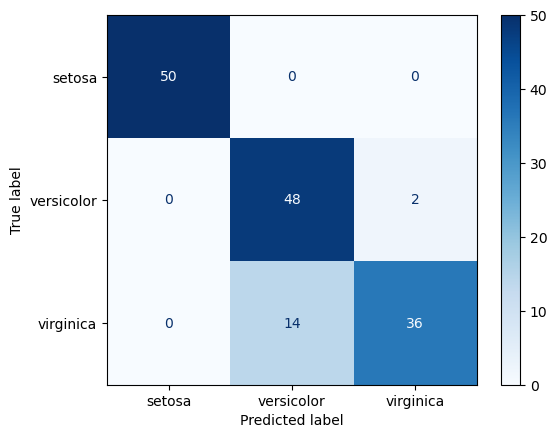

In [56]:
# C'è sempre da rimappare le etichette
y_3_remap = remap_cluster(y_3_kmeans,((0,1),(1,0),(2,2)))

cm3 = confusion_matrix(y,y_3_remap)

ConfusionMatrixDisplay.from_predictions(y, y_3_remap, display_labels=iris.target_names, cmap=plt.cm.Blues)

# Calcoliamo le metriche di bontà per il clustering a 3 dimensioni
purity, gini = cluster_metrics(cm3)

print(f'Purity: {purity:5.2f}\nGini index: {gini:5.2f}')

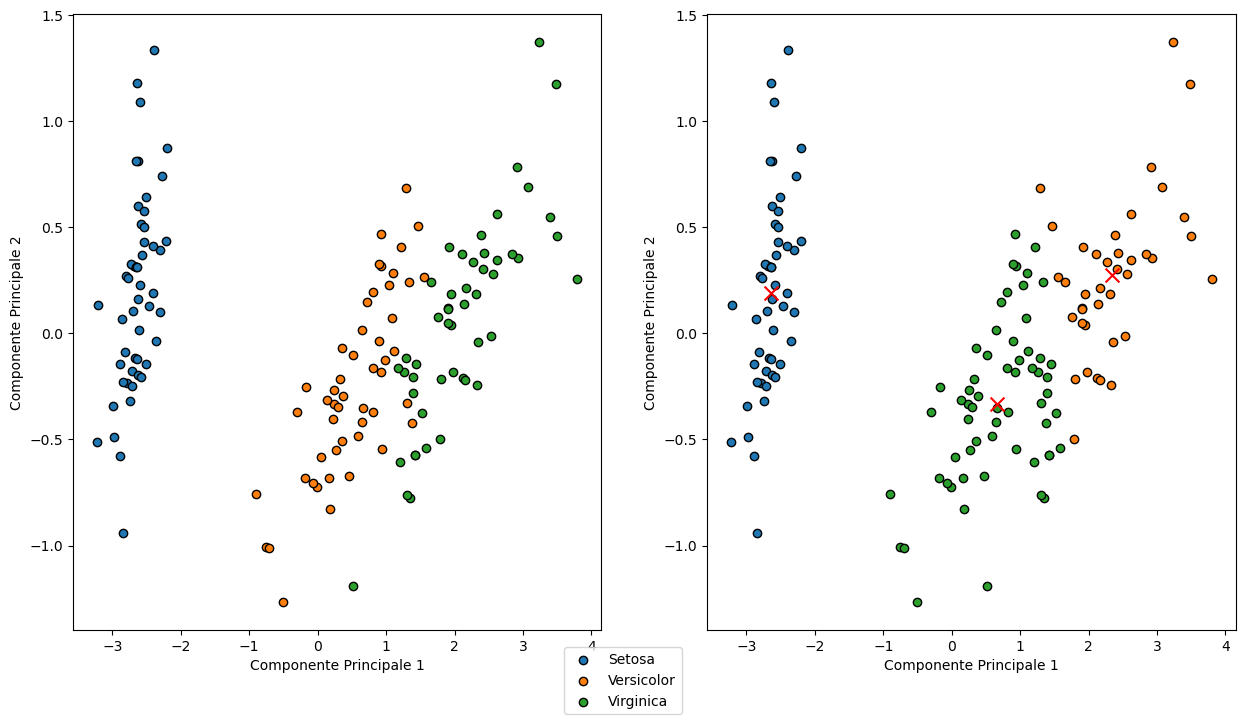

In [59]:
# Clustering a 2 dimensioni
kmeans2 = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)

y_2_kmeans = kmeans2.fit_predict(X_2)

# Eseguiamo il plot dei risultati del clustering
fig = plt.figure(figsize=(15, 8))

# Grafico 1: data set reale
subplt = fig.add_subplot(121)

subplt.set_xlabel('Componente Principale 1')
subplt.set_ylabel('Componente Principale 2')

subplt.scatter(X_2[y==0,0],X_2[y==0,1],label='Setosa', edgecolor='k')
subplt.scatter(X_2[y==1,0],X_2[y==1,1],label='Versicolour',edgecolor='k')
subplt.scatter(X_2[y==2,0],X_2[y==2,1],label='Virginica',edgecolor='k')

# Grafico 2: risultati del clustering con i centri cluster

subplt = fig.add_subplot(122)

subplt.set_xlabel('Componente Principale 1')
subplt.set_ylabel('Componente Principale 2')

subplt.scatter(X_2[y_2_kmeans==0,0],X_2[y_2_kmeans==0,1],label='Setosa', edgecolor='k')
subplt.scatter(X_2[y_2_kmeans==1,0],X_2[y_2_kmeans==1,1],label='Versicolour',edgecolor='k')
subplt.scatter(X_2[y_2_kmeans==2,0],X_2[y_2_kmeans==2,1],label='Virginica',edgecolor='k')

subplt.scatter(kmeans2.cluster_centers_[:,0],
               kmeans2.cluster_centers_[:,1],
               s=100,
               marker='x',
               c='r')


fig.legend(('Setosa','Versicolor','Virginica'),loc='lower center')

plt.show()

Purity:  0.89
Gini index:  0.17


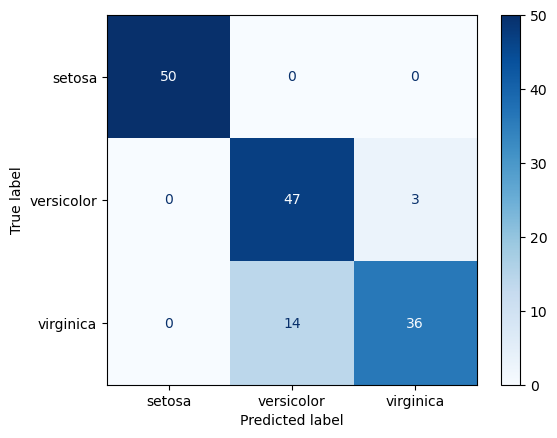

In [60]:
# Effettuiamo il remap e poi calcoliamo la matrice di confusione e gli indici di bontà del clustering
y_2_remap = remap_cluster(y_2_kmeans,((0,0),(1,2),(2,1)))

cm2 = confusion_matrix(y,y_2_remap)

ConfusionMatrixDisplay.from_predictions(y, y_2_remap, display_labels=iris.target_names, cmap=plt.cm.Blues)

# Calcoliamo le metriche di bontà per il clustering a 3 dimensioni
purity, gini = cluster_metrics(cm2)

print(f'Purity: {purity:5.2f}\nGini index: {gini:5.2f}')